In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import genemunge

# Searching the gene ontology for relevant genes

In [2]:
# set up an object to search the gene ontology
searcher = genemunge.search.Searcher()

# get all of the GO identifiers associated with the word 'immune'
# set exact = False to walk through the ontology and grab all child terms
immune_identifiers = searcher.keyword_search(['immune'], exact=False)

# get all of the genes assigned to the immune_identifiers
immune_genes = searcher.get_genes(immune_identifiers)

# get a list of housekeeping genes
housekeeping = searcher.get_housekeeping_genes()

# keep all of the immune related genes that are not housekeeping genes
variable_immune_genes = list(set(immune_genes) - set(housekeeping))

print('Identified {} variable immune related genes'.format(len(variable_immune_genes)))

Identified 2412 variable immune related genes


# Converting between gene identifier types

In [3]:
# set up an object to convert from ensembl to symbol
ensembl_to_symbol = genemunge.convert.IDConverter('ensembl_gene_id', 'symbol')

# convert the immune identifiers to gene symbols
variable_immune_symbols = ensembl_to_symbol.convert_list(variable_immune_genes)

# Obtaining statistics about gene expression

In [4]:
# set up an object to describe genes
describer = genemunge.describe.Describer('symbol')

In [5]:
# find the absolute and relative expression levels of each gene of interest
expression_data = pd.DataFrame(index=variable_immune_symbols,
                               columns=['expression', 'log ratio'])
for gene in variable_immune_symbols:
    # get the expression levels in healthy tissue (in TPM units)
    try:
        stats = describer.get_tissue_expression(gene)
        stomach_med = stats['median'].loc['Stomach']
        small_intestine_med = stats['median'].loc['Small Intestine']
    # some genes are not in GTEx - set expression to 0
    except KeyError:
        stomach_med = 0.0
        small_intestine_med = 0.0
    # control the log with a small pseudocount
    pseudocount = 1.0
    expr_ratio = (pseudocount+small_intestine_med) / (pseudocount+stomach_med)
    expression_data.loc[gene] = [small_intestine_med, np.log10(expr_ratio)]

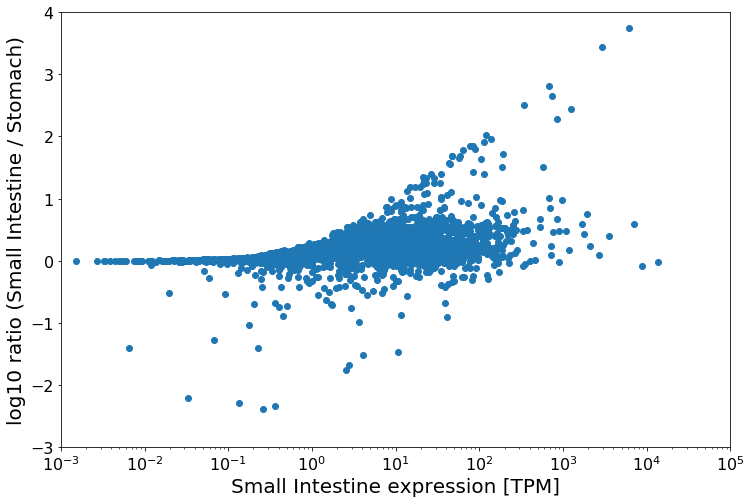

In [6]:
# plot the gene expression fraction
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.scatter(expression_data['expression'], expression_data['log ratio'])
ax.set_xlabel('Small Intestine expression [TPM]', fontsize=20)
ax.set_ylabel('log10 ratio (Small Intestine / Stomach)', fontsize=20)
ax.set_xscale('log')
ax.set_xlim([0.001, 1e5])
ax.set_ylim([-3, 4])
plt.savefig('small_intestine_example.png', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
target_genes = expression_data[expression_data['log ratio'] > 1]
target_genes = target_genes.sort_values(by=['expression'], ascending=False)
target_genes

,expression,log ratio
DEFA5,6191.24,3.74383
DEFA6,2926.39,3.44277
REG3A,1242.48,2.44208
ANPEP,849.591,2.28874
OLFM4,746.084,2.64793
IGHM,686.471,1.00854
APOA4,676.216,2.80445
PLA2G2A,581.161,1.50555
MUC2,343.715,2.50565
MUC13,190.013,1.72095


# Getting information about a specific gene

{
  "ensembl": "ENSG00000164816",
  "symbol": "DEFA5",
  "name": "defensin alpha 5",
  "ontology": {
    "GO:0061844": "antimicrobial humoral immune response mediated by antimicrobial peptide",
    "GO:0071222": "cellular response to lipopolysaccharide",
    "GO:0019730": "antimicrobial humoral response",
    "GO:0045087": "innate immune response",
    "GO:0030133": "transport vesicle",
    "GO:0031640": "killing of cells of other organism",
    "GO:0019731": "antibacterial humoral response",
    "GO:0050829": "defense response to Gram-negative bacterium",
    "GO:0050832": "defense response to fungus",
    "GO:0005796": "Golgi lumen",
    "GO:0042803": "protein homodimerization activity",
    "GO:1905710": "positive regulation of membrane permeability",
    "GO:0034774": "secretory granule lumen",
    "GO:0002227": "innate immune response in mucosa",
    "GO:0005615": "extracellular space",
    "GO:0050830": "defense response to Gram-positive bacterium",
    "GO:0051673": "membrane di

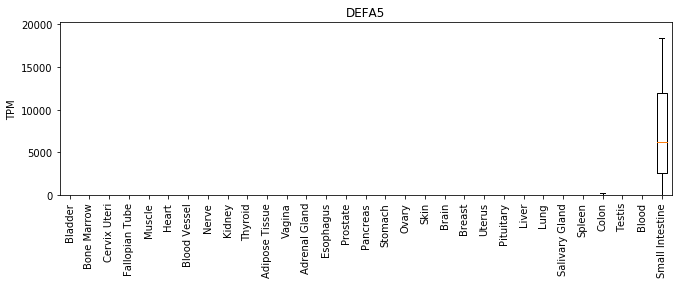

In [8]:
# set up an object to describe genes
describer = genemunge.describe.Describer('symbol')

# get some basic information about one of the immune genes
print(json.dumps(describer.get_gene_info(target_genes.index[0]), indent=2))

# make a plot of the expression of one of the immune genes across tissues from GTEx
describer.plot_tissue_expression(target_genes.index[0], sortby='median',
                                 filename='gene_expr_example.png')